In [92]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input, layers, optimizers

from matplotlib import pyplot as plt

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [93]:

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

"""
## define the encoder
"""

def encoder(latent_dim=2):

    encoder_inputs = tf.keras.Input(shape=(56, 1))
    x = layers.Conv1D(32, 5, activation="relu", strides=1, padding="same")(encoder_inputs)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(64, 5, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(14, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder


"""
## define the decoder
"""

def generator(latent_dim=2):

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = layers.Dense(14, activation="relu")(latent_inputs)
    x = layers.Reshape((14, 1))(x)
    x = layers.Conv1DTranspose(64, 5, activation="relu", strides=1, padding="same")(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1DTranspose(32, 5, activation="relu", strides=1, padding="same")(x)
    x = layers.UpSampling1D(size=2)(x)
    decoder_outputs = layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return decoder

def critic():
    
    critic_inputs = tf.keras.Input(shape=(56, 1))
    x = layers.Conv1D(32, 5, activation="relu", strides=1, padding="same")(critic_inputs)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Conv1D(64, 5, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(14, activation="relu")(x)
    critic_output = layers.Dense(1, activation=None)(x)

    critic = tf.keras.Model(critic_inputs, critic_output, name="critic")
    critic.summary()
    return critic

In [94]:
class VAEGAN(Model):
    
    def __init__(self, encoder, generator, critic, alpha=1., beta=10., gp_weight=10., **kwargs):
        super(VAEGAN, self).__init__(**kwargs)
        self.e = encoder
        self.g = generator
        self.c = critic
        self.alpha = alpha
        self.beta = beta
        self.gp_weight = gp_weight
        self.n_latent = generator.input_shape[-1]
        
    def compile(self, e_opt, g_opt, c_opt):
        super(VAEGAN, self).compile()
        self.e_opt = e_opt
        self.g_opt = g_opt
        self.c_opt = c_opt
        
    def sample(self, eps=None, batch_size=100):
        if not eps:
            eps = tf.random.normal((batch_size, self.n_latent))
        x = self.g(eps)
        return x
    
    def gradient_penalty(self, xreal, xfake):
        batch_size = tf.shape(xreal)[0]
        alphas = tf.random.uniform([batch_size,1,1], 0., 1.)
        x = alphas*xreal + (1.-alphas)*xfake
        with tf.GradientTape() as tape:
            tape.watch(x)
            s = self.c(x)
        grad = tape.gradient(s, [x])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2]))
        gp = tf.reduce_mean((slopes-1.)**2)
        return gp
    
    def encode(self, x):
        mean, logvar, z = self.e(x)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
            eps = tf.random.normal(shape=tf.shape(mean))
            return eps*tf.exp(logvar*.5) + mean
    
    def analytic_kl(self, mean, logvar):
        kl = -.5*tf.reduce_mean(logvar - tf.square(mean) - tf.exp(logvar) + 1)
        return kl
    
    def mse_loss(self, x, x_):
        mse = tf.reduce_sum(tf.square(x-x_), axis=[1, 2])
        return mse
    
    @tf.function
    def train_step(self, xreal):
        batch_size = tf.shape(xreal)[0]
        noise = tf.random.normal((batch_size, self.n_latent))
        with tf.GradientTape() as etape, tf.GradientTape() as gtape, tf.GradientTape() as ctape:
            mean, logvar = self.encode(xreal)
            z = self.reparametrize(mean, logvar)
            xrec = self.g(z)
            xfake = self.g(noise)
            s = self.c(xreal)
            srec = self.c(xrec)
            sfake = self.c(xfake)
            
            wdist = tf.reduce_mean(s) - tf.reduce_mean(tf.concat([srec, sfake], axis=0))
            rec_error = self.mse_loss(xreal, xrec)
            kl = self.analytic_kl(mean, logvar)
            gp = self.gradient_penalty(tf.concat([xreal, xreal], axis=0), tf.concat([xrec, xfake], axis=0))
            
            e_loss = rec_error + self.beta*kl
            g_loss = rec_error + self.alpha*wdist
            c_loss = -wdist + self.gp_weight*gp
            
        e_grad = etape.gradient(e_loss, self.e.trainable_variables)
        g_grad = gtape.gradient(g_loss, self.g.trainable_variables)
        c_grad = ctape.gradient(c_loss, self.c.trainable_variables)
        
        self.e_opt.apply_gradients(zip(e_grad, self.e.trainable_variables))
        self.g_opt.apply_gradients(zip(g_grad, self.g.trainable_variables))
        self.c_opt.apply_gradients(zip(c_grad, self.c.trainable_variables))
        
        return {
            'wdist' : wdist,
            'rec_error' : rec_error,
            'kl' : kl,
            'gp' : gp,
            'e_loss' : e_loss,
            'g_loss' : g_loss,
            'c_loss' : c_loss
        }

    @tf.function
    def test_step(self, xreal):
        batch_size = tf.shape(xreal)[0]
        noise = tf.random.normal((batch_size, self.n_latent))

        mean, logvar = self.encode(xreal)
        z = self.reparametrize(mean, logvar)
        xrec = self.g(z)
        xfake = self.g(noise)
        s = self.c(xreal)
        srec = self.c(xrec)
        sfake = self.c(xfake)
        
        wdist = tf.reduce_mean(s) - tf.reduce_mean(tf.concat([srec, sfake], axis=0))
        rec_error = self.mse_loss(xreal, xrec)
        kl = self.analytic_kl(mean, logvar)
        gp = self.gradient_penalty(tf.concat([xreal, xreal], axis=0), tf.concat([xrec, xfake], axis=0))
        
        e_loss = rec_error + self.beta*kl
        g_loss = rec_error + self.alpha*wdist
        c_loss = -wdist + self.gp_weight*gp
        
        return {
            'wdist' : wdist,
            'rec_error' : tf.math.reduce_mean(rec_error),
            'kl' : kl,
        }
        
        

In [95]:
input_data = np.load('../data/phase_dataset_alice.npy')
print(np.shape(input_data))
train_data = input_data[0:512*1000]
test_data = input_data[512*1000:512*1200]
print(np.shape(train_data))
print(np.shape(test_data))

(847358, 56, 1)
(512000, 56, 1)
(102400, 56, 1)


In [104]:

"""
## Train the VAE
"""

latent_dim = 10
alpha = 0.1
beta = 0.1
gp_weight = 10
epochs = 5

print("Latent dims:", latent_dim)
print("Alpha:", alpha)
print("Beta:", beta)
print("GP weight:", gp_weight)

vae = VAEGAN(encoder(latent_dim), generator(latent_dim), critic(), alpha=alpha, beta=beta, gp_weight=gp_weight)
e_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
g_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
c_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
vae.compile(e_opt, g_opt, c_opt)
vae.fit(train_data, epochs=epochs, batch_size=512)

Latent dims: 10
Alpha: 0.1
Beta: 0.1
GP weight: 10
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_181 (InputLayer)         [(None, 56, 1)]      0           []                               
                                                                                                  
 conv1d_240 (Conv1D)            (None, 56, 32)       192         ['input_181[0][0]']              
                                                                                                  
 max_pooling1d_240 (MaxPooling1  (None, 28, 32)      0           ['conv1d_240[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1d_241 (Conv1D)            (None, 28

In [105]:
print(vae)
vae.evaluate(test_data, batch_size=512)

200/200 [==============================] - 2s 6ms/step - wdist: 0.0049 - rec_error: 0.0244 - kl: 0.4152


[0.41293469071388245, 0.02357616275548935, 0.006241917610168457]

In [98]:
from tensorboard.plugins.hparams import api as hp

HP_LATENT_DIMS = hp.HParam('latent_dims', hp.Discrete([3, 10]))
HP_ALPHA = hp.HParam('alpha', hp.RealInterval(0.1, 2.))
HP_BETA = hp.HParam('beta', hp.RealInterval(0.1, 2.))
HP_GPWEIGHT = hp.HParam('gp_weight', hp.RealInterval(1., 10.))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_LATENT_DIMS, HP_ALPHA, HP_BETA, HP_GPWEIGHT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

def train_test_model(hparams):
  model = VAEGAN(encoder(hparams[HP_LATENT_DIMS]), generator(hparams[HP_LATENT_DIMS]), critic(), alpha=hparams[HP_ALPHA], beta=hparams[HP_BETA], gp_weight=hparams[HP_GPWEIGHT])
  e_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
  g_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
  c_opt = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0., beta_2=.9)
  model.compile(e_opt, g_opt, c_opt)

  model.fit(train_data, epochs=epochs, batch_size=512)
  _, accuracy, _ = model.evaluate(test_data)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


session_num = 0
res = 2

for latent_dim in HP_LATENT_DIMS.domain.values:
  for alpha in np.linspace(HP_ALPHA.domain.min_value, HP_ALPHA.domain.max_value, res):
    for beta in np.linspace(HP_BETA.domain.min_value, HP_BETA.domain.max_value, res):
      for gp_weight in np.linspace(HP_GPWEIGHT.domain.min_value, HP_GPWEIGHT.domain.max_value, res):
        hparams = {
            HP_LATENT_DIMS: latent_dim,
            HP_ALPHA: alpha,
            HP_BETA: beta,
            HP_GPWEIGHT: gp_weight
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1



--- Starting trial: run-0
{'latent_dims': 3, 'alpha': 0.1, 'beta': 0.1, 'gp_weight': 1.0}
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_133 (InputLayer)         [(None, 56, 1)]      0           []                               
                                                                                                  
 conv1d_176 (Conv1D)            (None, 56, 32)       192         ['input_133[0][0]']              
                                                                                                  
 max_pooling1d_176 (MaxPooling1  (None, 28, 32)      0           ['conv1d_176[0][0]']             
 D)                                                                                               
                                                                                                  
 c

In [103]:
%load_ext tensorboard
%tensorboard --logdir logs/hparam_tuning

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 78525), started 0:00:56 ago. (Use '!kill 78525' to kill it.)

1/1 [==============================] - 0s 21ms/step


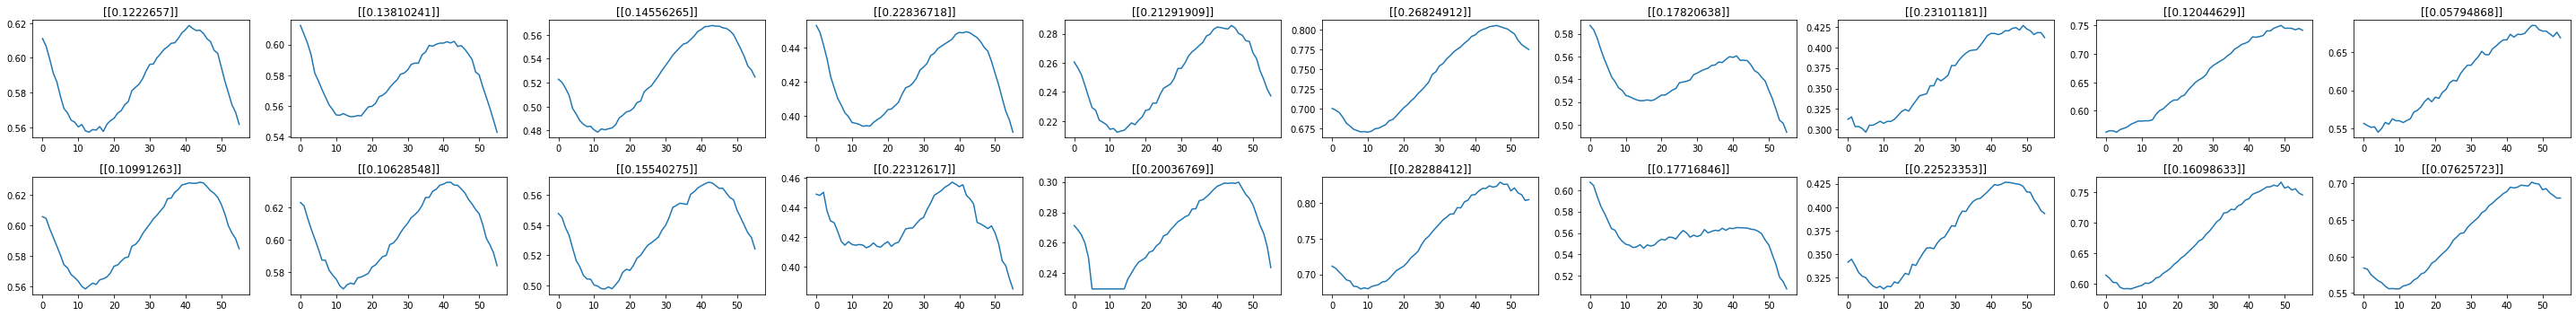

1/1 [==============================] - 0s 16ms/step


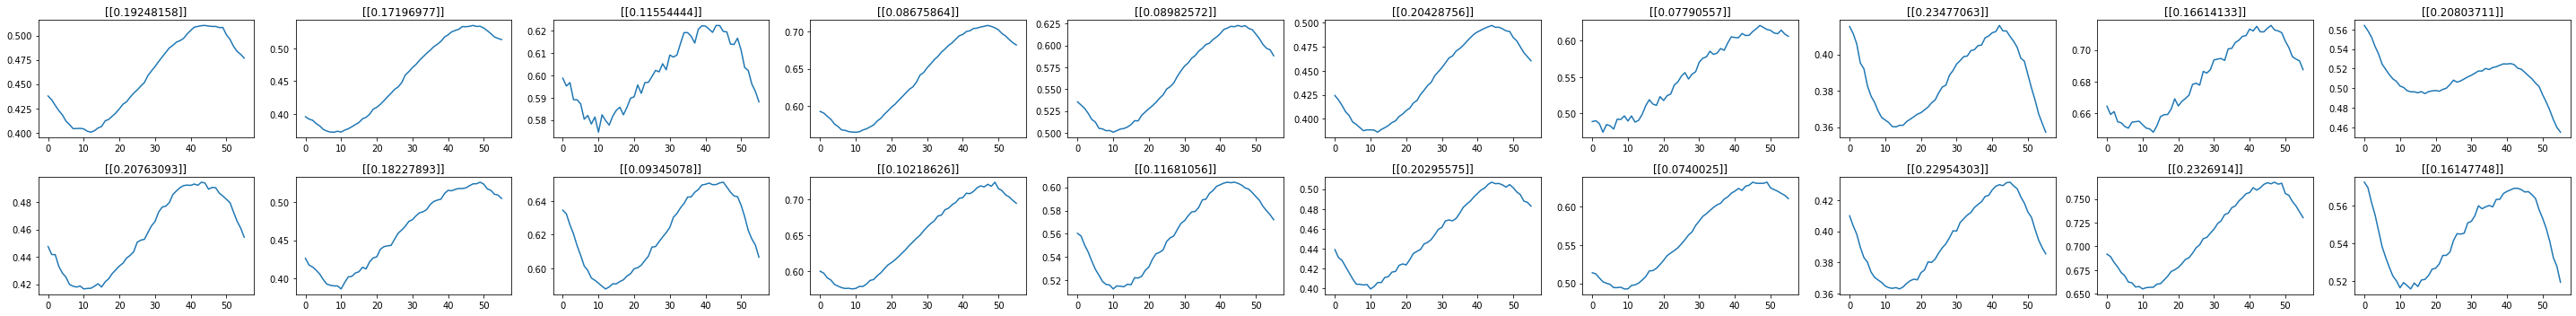

1/1 [==============================] - 0s 31ms/step


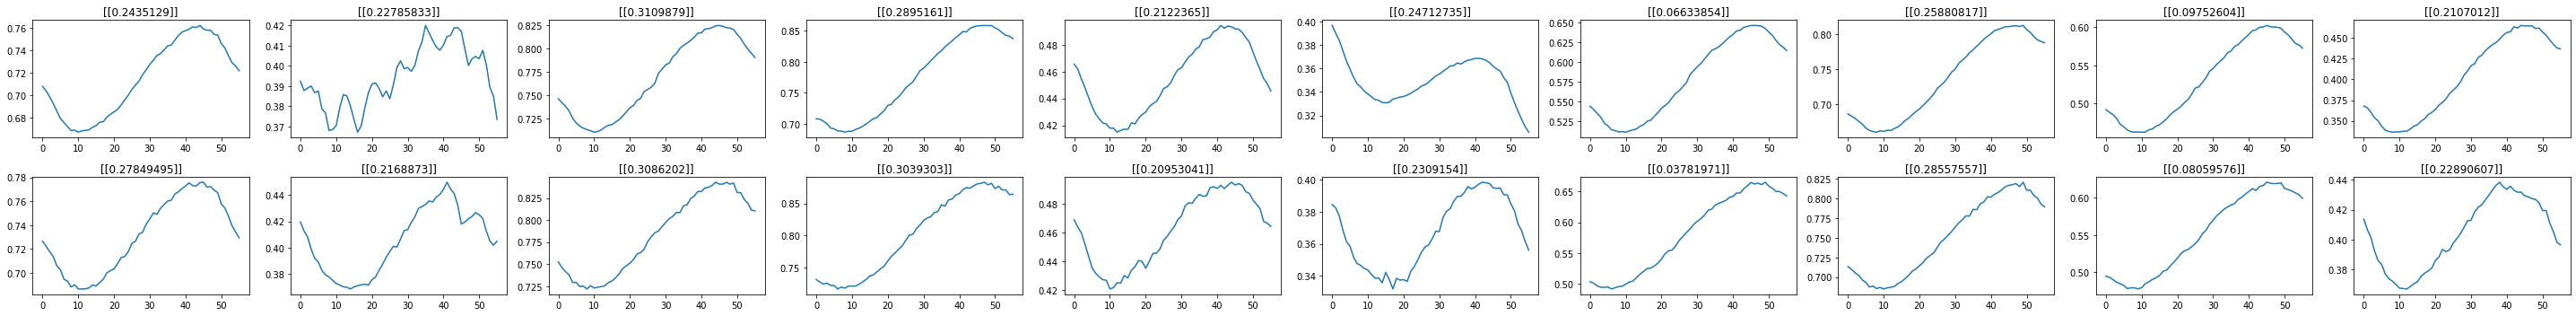

In [106]:

"""
## Evaluate reconstruction
"""

import matplotlib.pyplot as plt


def plot_reconstruction(vae, n=30):
    fig, axs = plt.subplots(2, n, figsize=(40, 5))

    for i in range(n):
        s = np.random.randint(0, 169472, 1)[0]
        data = np.expand_dims(input_data[s], axis=0)

        z_mean, z_log_var, z = vae.e(data)
        reconstruction = vae.g.predict(z)
        score_real = vae.c(data)
        score_fake = vae.c(reconstruction)

        axs[0, i].plot(np.squeeze(data))
        axs[1, i].plot(np.squeeze(reconstruction))
        #axs[1, i].set_ylabel(f"z: {z.numpy()}")
        axs[0, i].set_title(str(score_real.numpy()))
        axs[1, i].set_title(str(score_fake.numpy()))
    fig.tight_layout()
    plt.show()

plot_reconstruction(vae, n = 10)
plot_reconstruction(vae, n = 10)
plot_reconstruction(vae, n = 10)

1/1 [==============================] - 0s 28ms/step


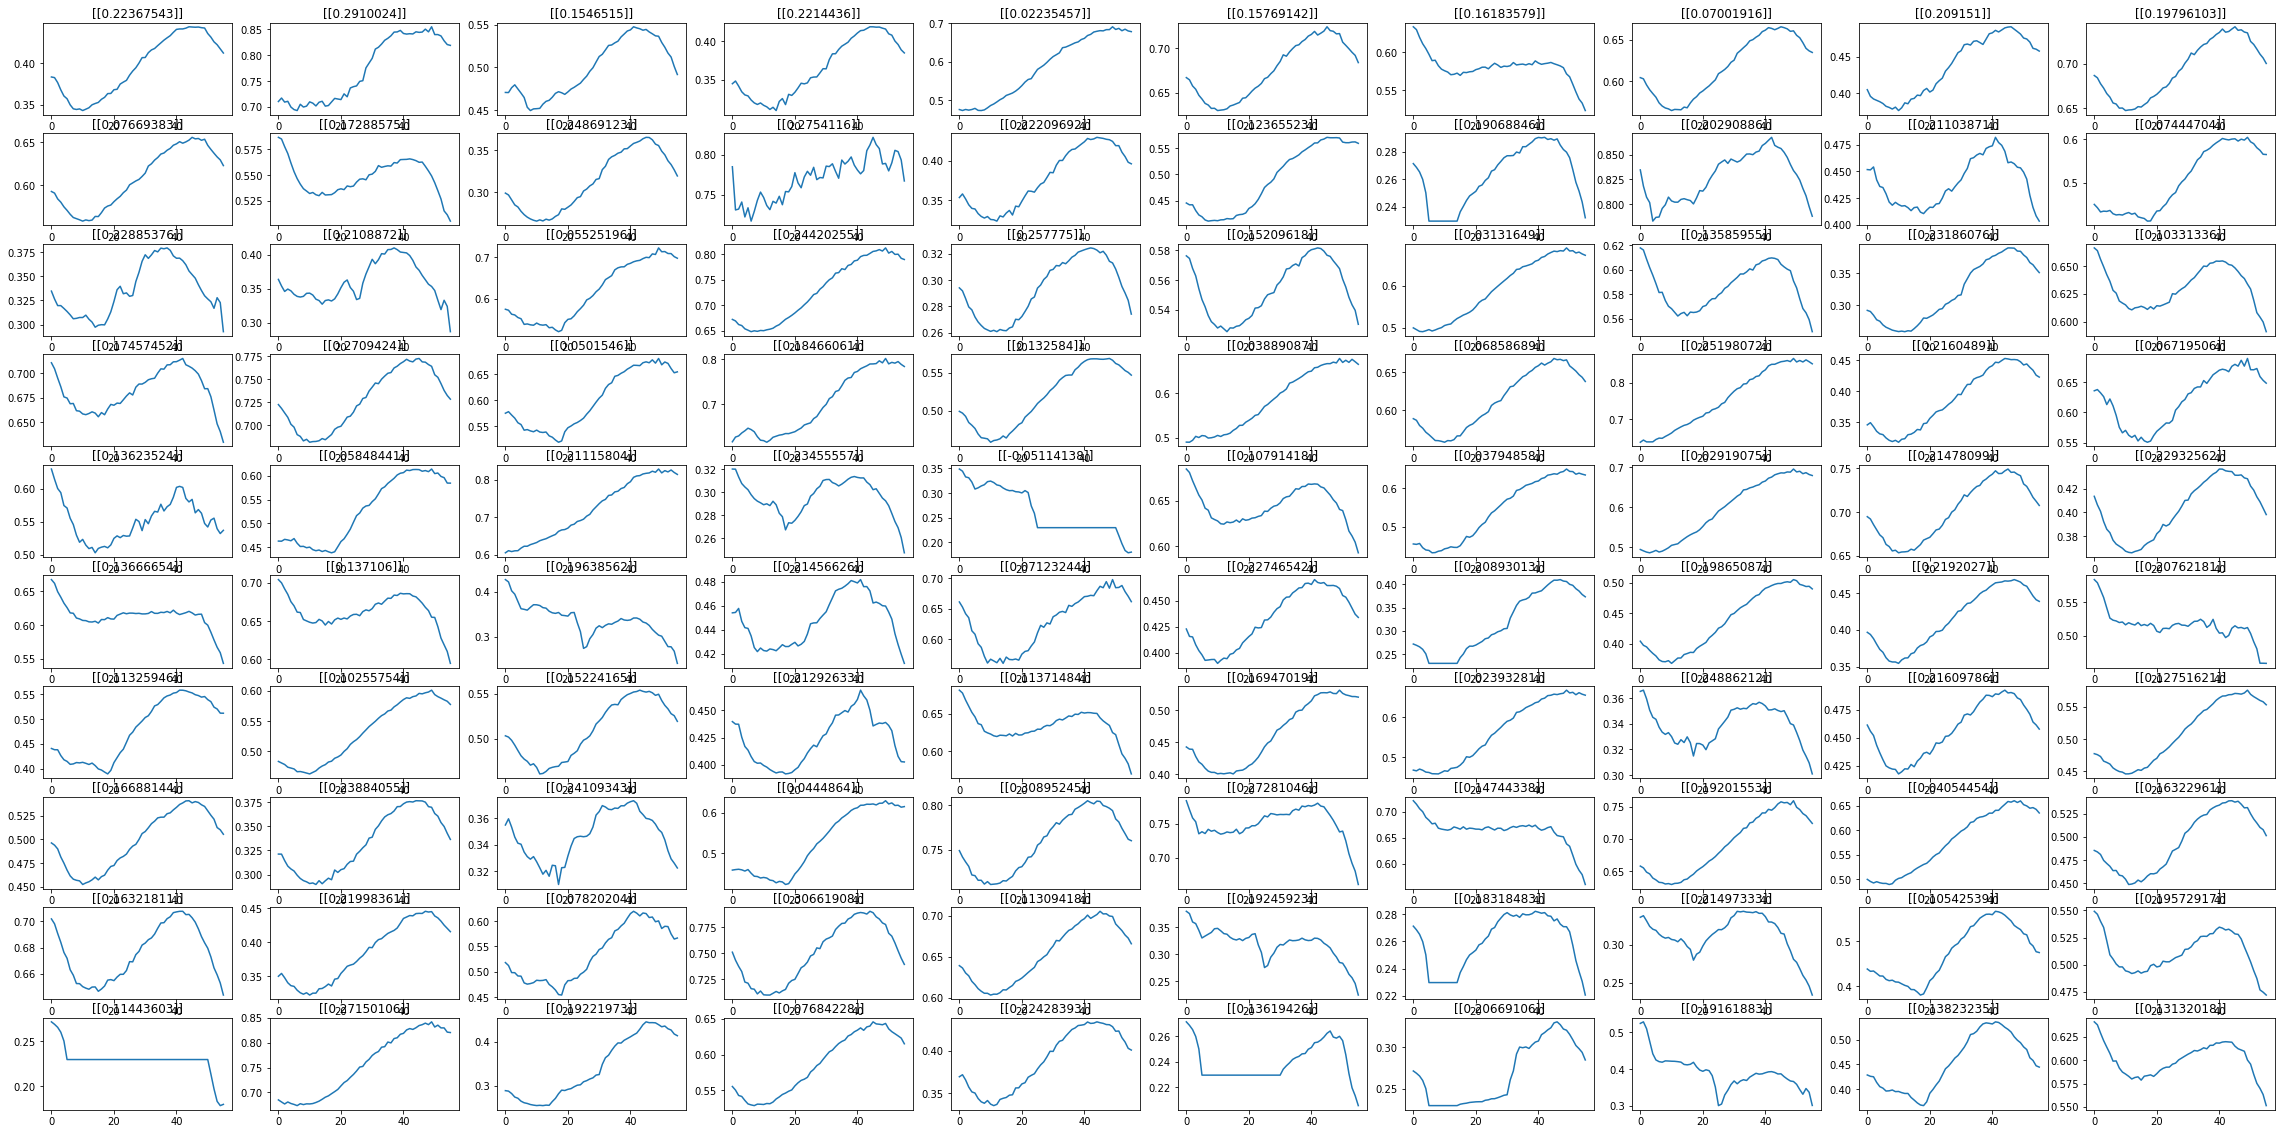

In [108]:

"""
## Generate fake samples
"""

import matplotlib.pyplot as plt


def gen_fake(vae, n=30, m=1):
    fig, axs = plt.subplots(m, n, figsize=(40, 2*m))
    

    for i in range(n):
        for j in range(m):
            # sample random data in latent space

            z = tf.random.normal([1, latent_dim])

            # run through generator
            x_tilde = vae.g.predict(z)
            c_x_tilde = vae.c(x_tilde)
        
            # plot
            axs[j, i].plot(np.squeeze(x_tilde))
            axs[j, i].set_title(str(c_x_tilde.numpy()))
    plt.show()

gen_fake(vae, n = 10, m = 10)

In [109]:
vae.save("trainedmodel")

ValueError: Model <__main__.VAEGAN object at 0x7f4c7888eac0> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.